<a href="https://colab.research.google.com/github/DesiPilla/MLTSA_DPilla/blob/master/HW9/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.



In [316]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way (i.e. that Yuqic an grade each notebook and the data will be accessed automatically without modifications to the code). You will need the training data and the metadata files


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd '/content/drive/My Drive/Colab Notebooks/MLTSA/plastic'

/content/drive/My Drive


In [14]:
lcvs = pd.read_csv("training_set.csv")
lcvs = lcvs[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (10000, 6)


In [15]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


For each object there are 6 time series in 6 different passbands (see overview.) 

In [16]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [17]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 31 astrophysical simulated objects in my dataset


# Gaussian Processing

In order to run the neural network, the inputs must all occur at the same time step. Because the data are not evenly sampled, I will use Gaussian Processing to generate a smooth curve of the data, and then take even samples from that distribution.

In [0]:
def make_gp(mjd, flux):
    '''This function uses Gaussian Processes to create an evenly sampled estimate
    of the time series'''

    # Standardize the data
    mjd_st = (mjd - mjd.mean()) / mjd.std()
    flux_st = (flux - flux.mean()) / flux.std()

    # Fit the Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.015)
    gpr.fit(mjd_st.reshape(-1, 1), flux_st)

    # Predict the flux for evenly spaced time samples 
    mjd_even_st = np.linspace((0 - mjd.mean()) / mjd.std(), (900 - mjd.mean()) / mjd.std())
    flux_even_st, sigma = gpr.predict(mjd_even_st.reshape(-1, 1), return_std=True)

    # Unstandardize evenly spaced data
    mjd_even = mjd_even_st * mjd.std() + mjd.mean()
    flux_even = flux_even_st * flux.std() + flux.mean()
    sigma = sigma * flux.std() + flux.mean()

    return mjd_even, flux_even

Fitting object 1/31
Fitting object 2/31
Fitting object 3/31
Fitting object 4/31
Fitting object 5/31
Fitting object 6/31
Fitting object 7/31
Fitting object 8/31
Fitting object 9/31
Fitting object 10/31
Fitting object 11/31
Fitting object 12/31
Fitting object 13/31
Fitting object 14/31
Fitting object 15/31
Fitting object 16/31
Fitting object 17/31
Fitting object 18/31
Fitting object 19/31
Fitting object 20/31
Fitting object 21/31
Fitting object 22/31
Fitting object 23/31
Fitting object 24/31
Fitting object 25/31
Fitting object 26/31
Fitting object 27/31
Fitting object 28/31
Fitting object 29/31
Fitting object 30/31
Fitting object 31/31


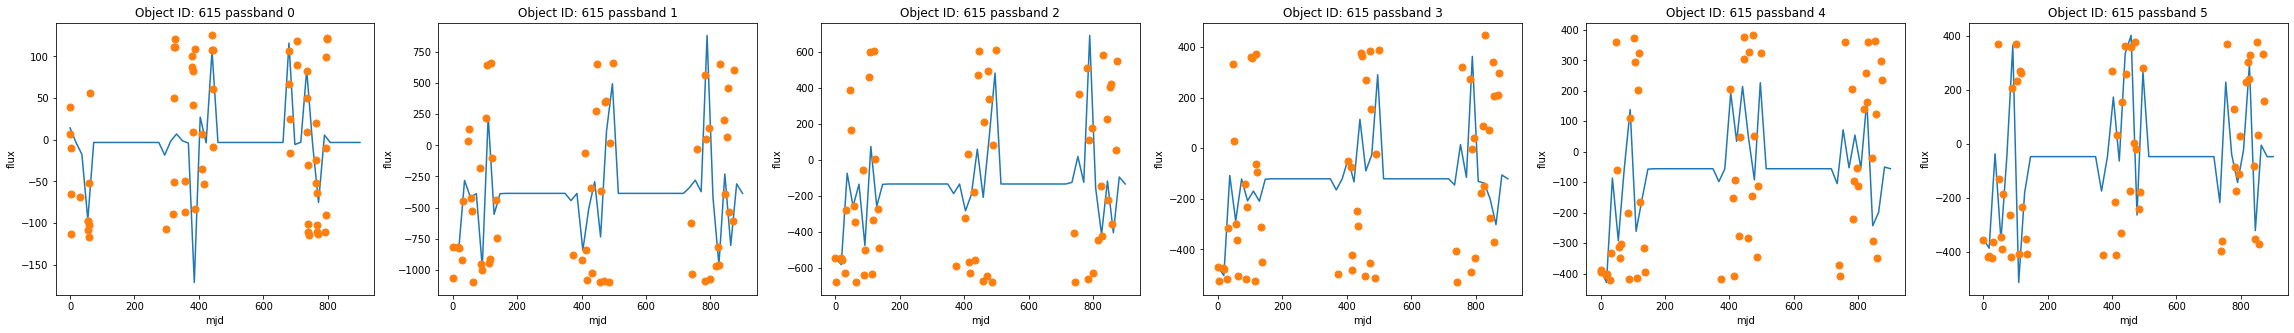

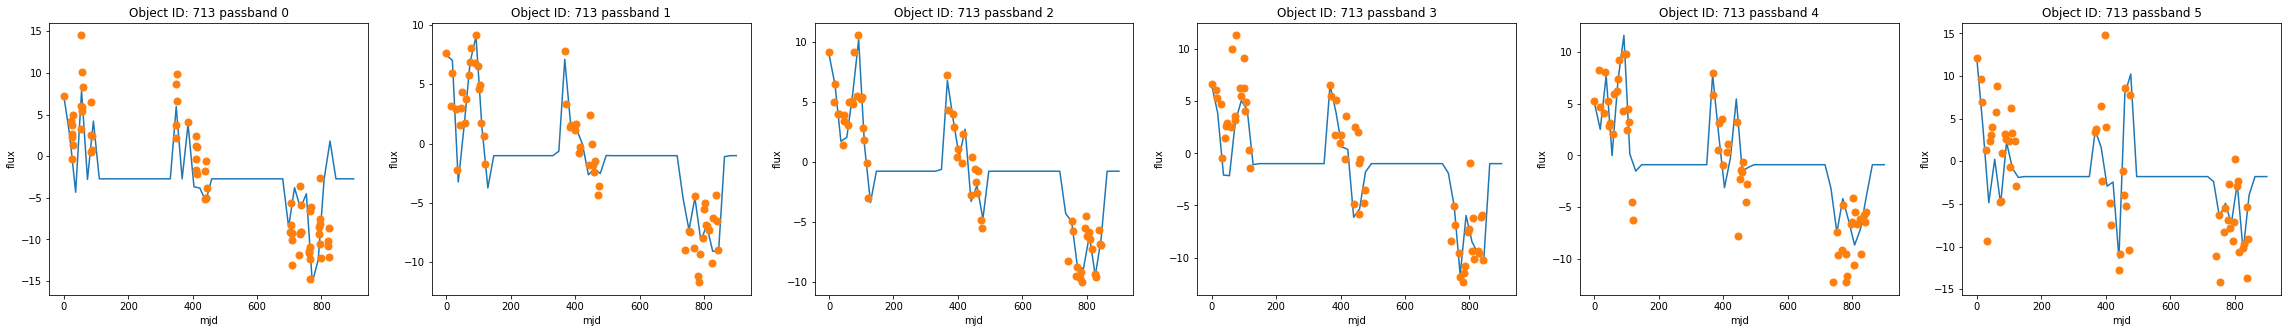

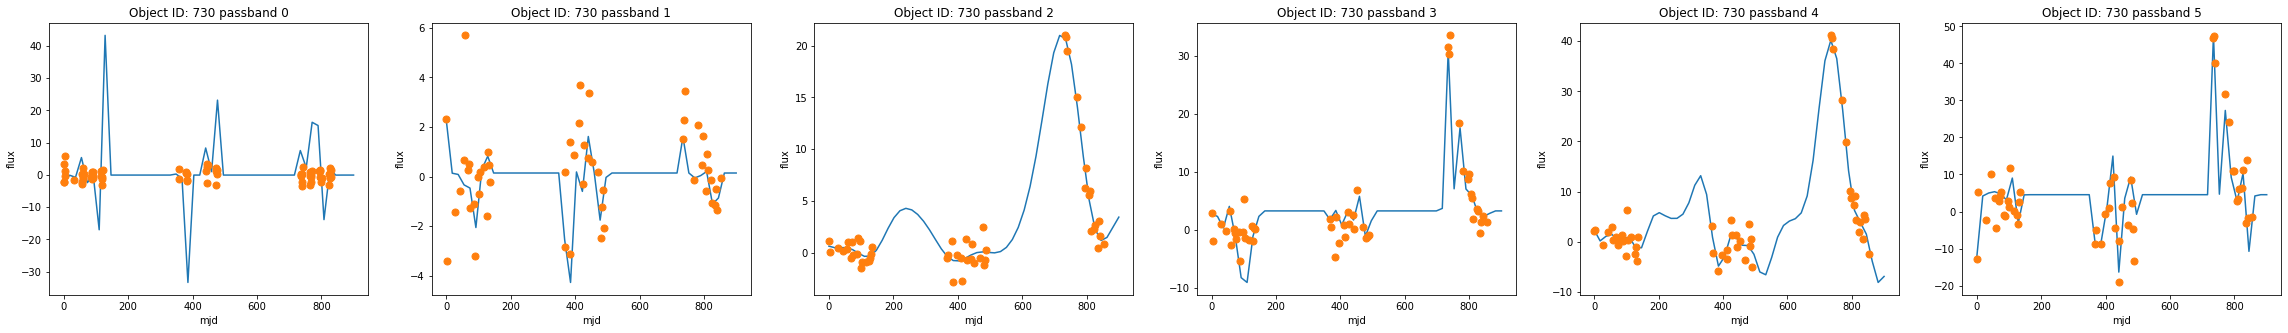

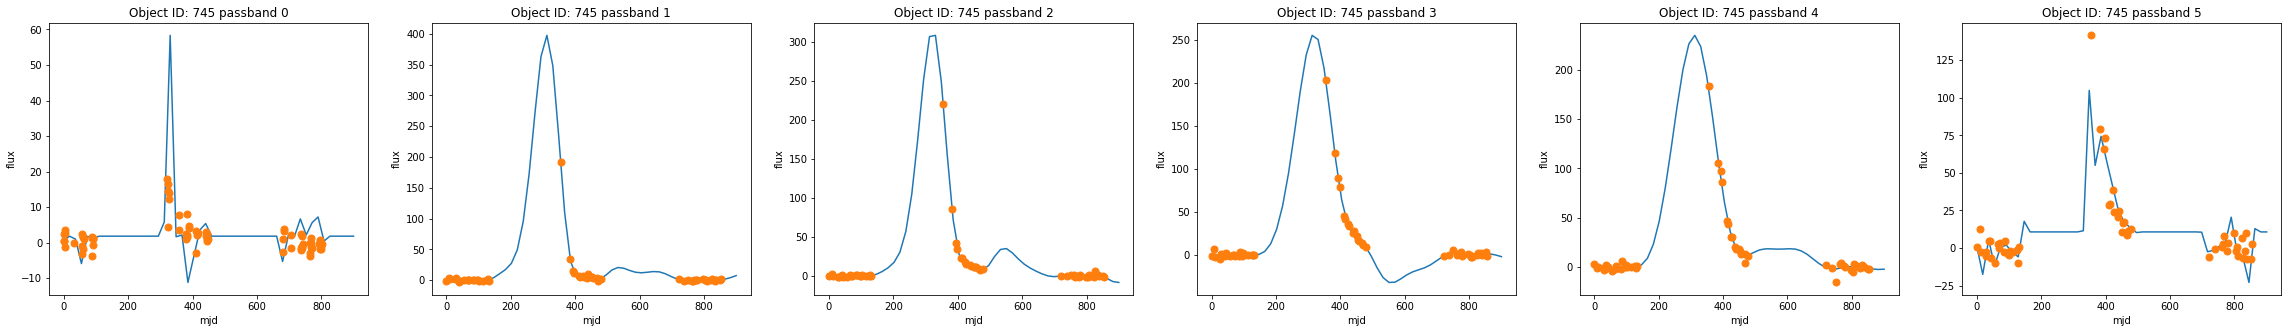

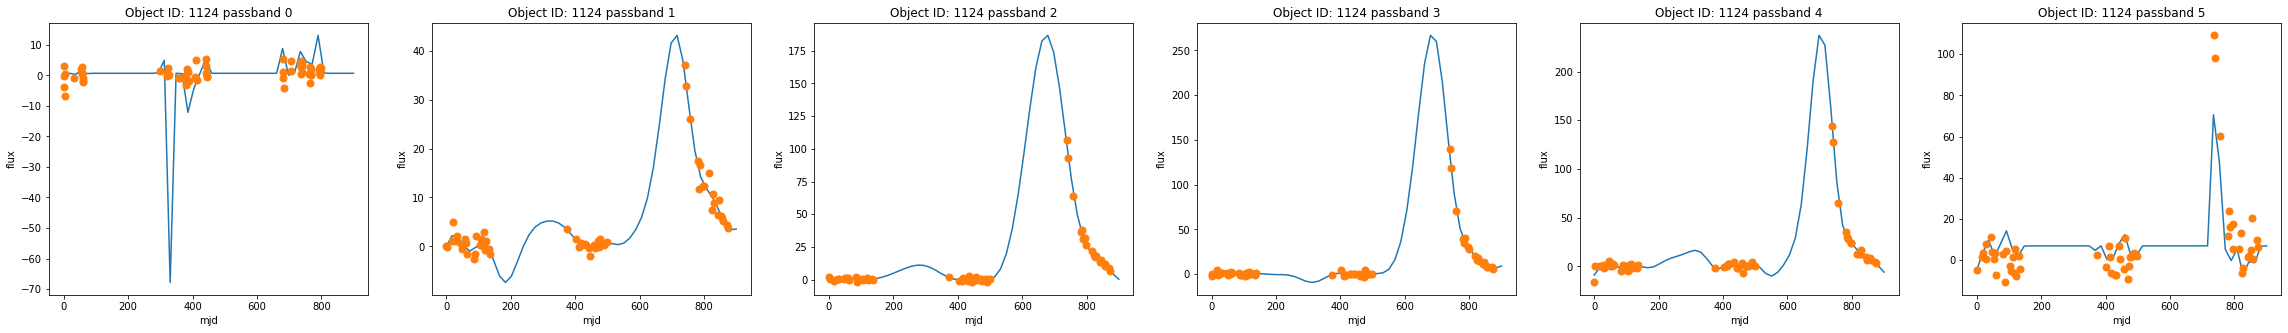

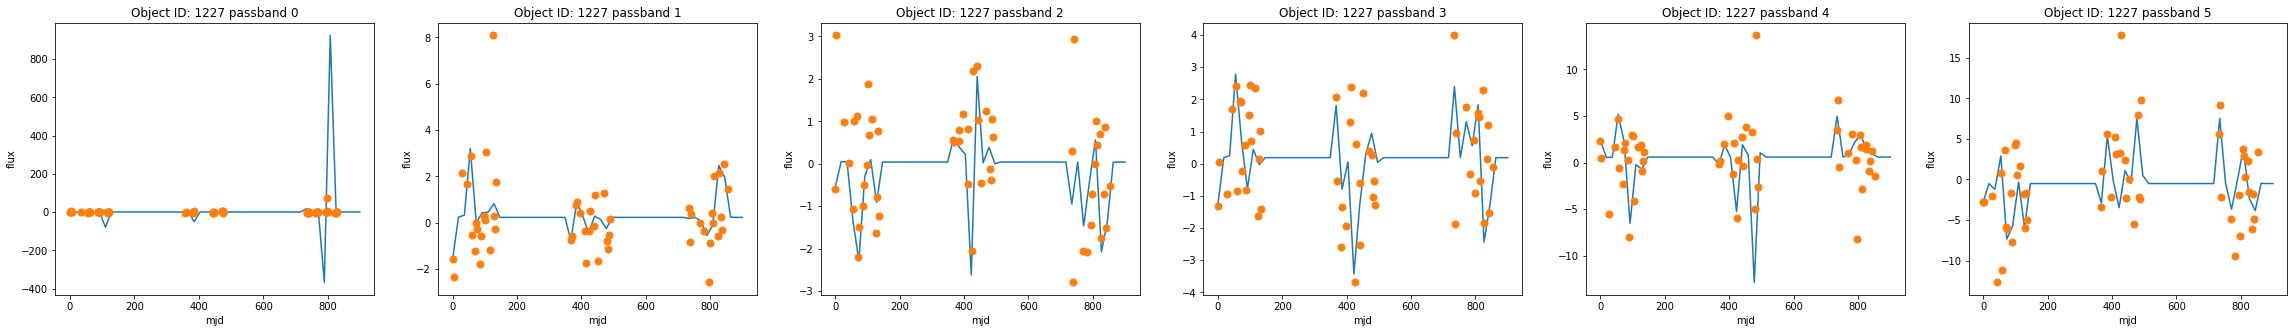

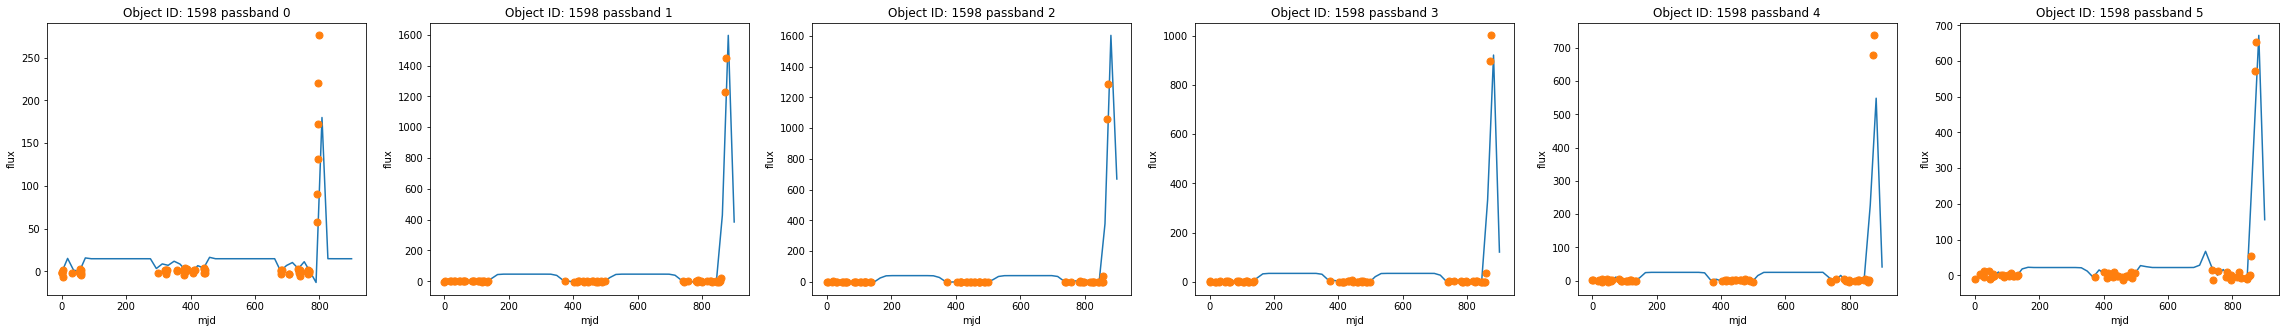

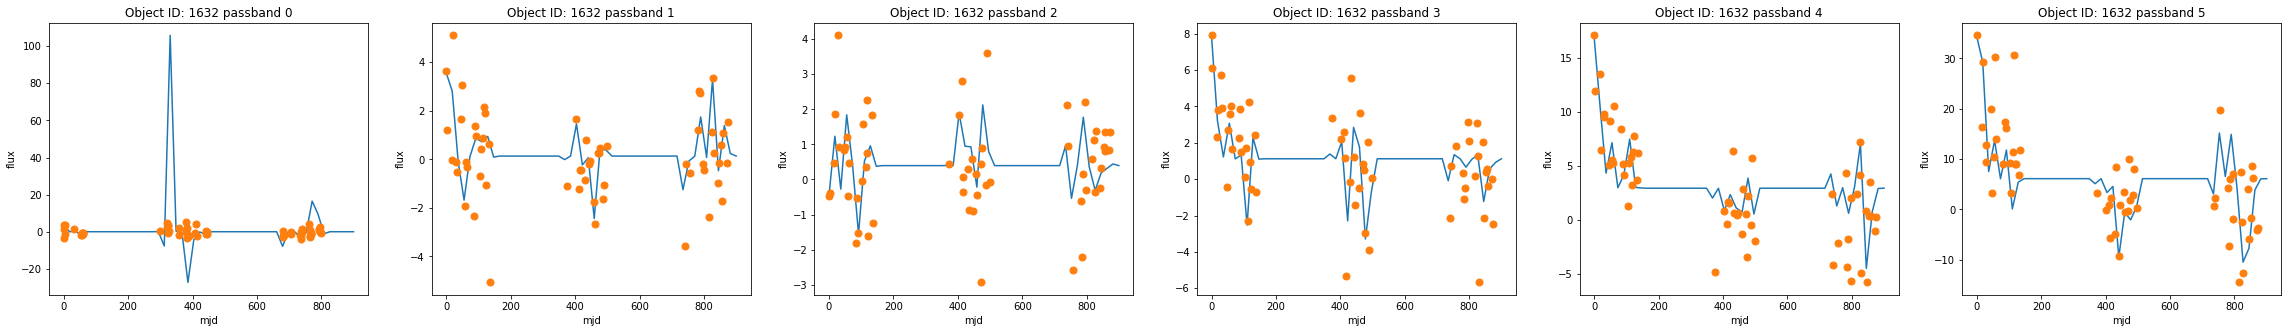

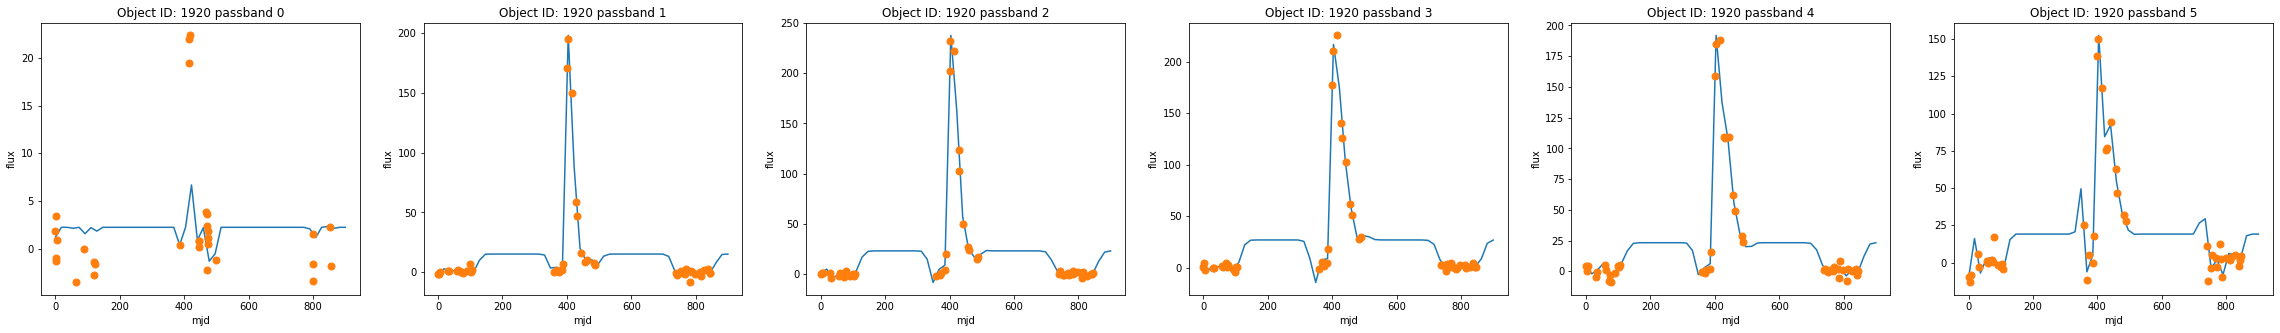

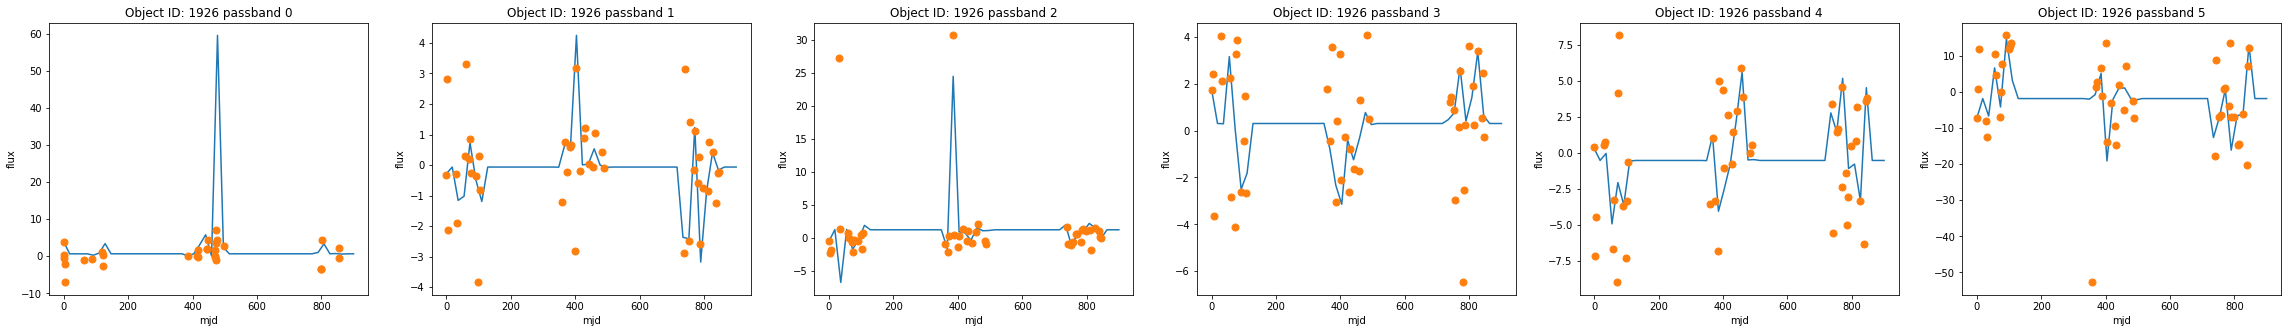

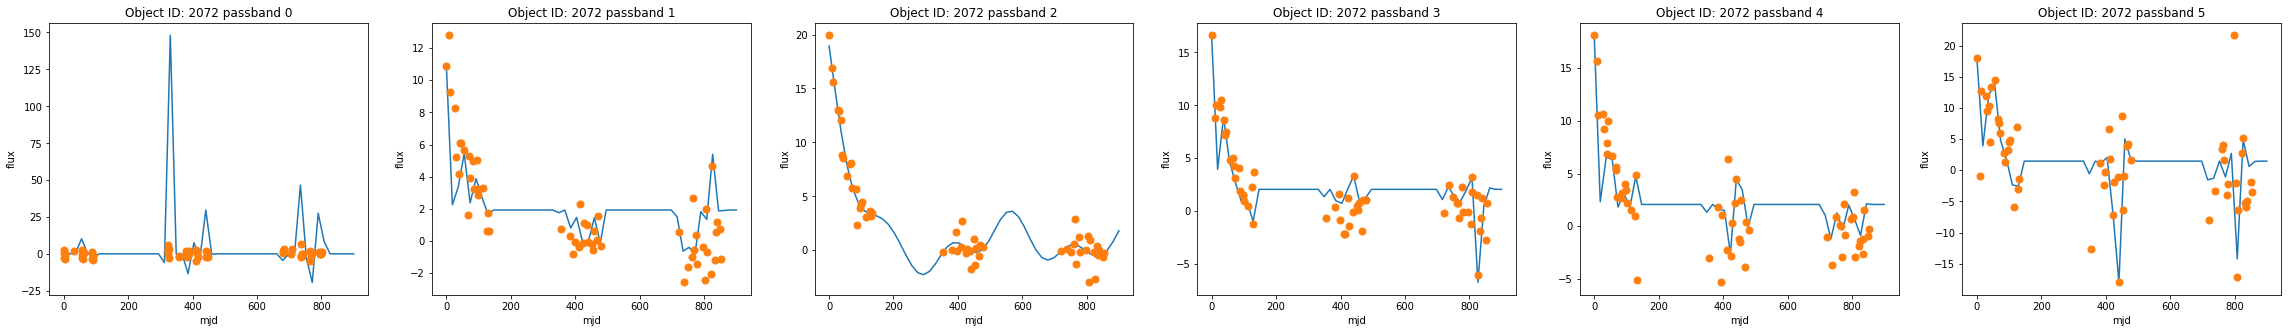

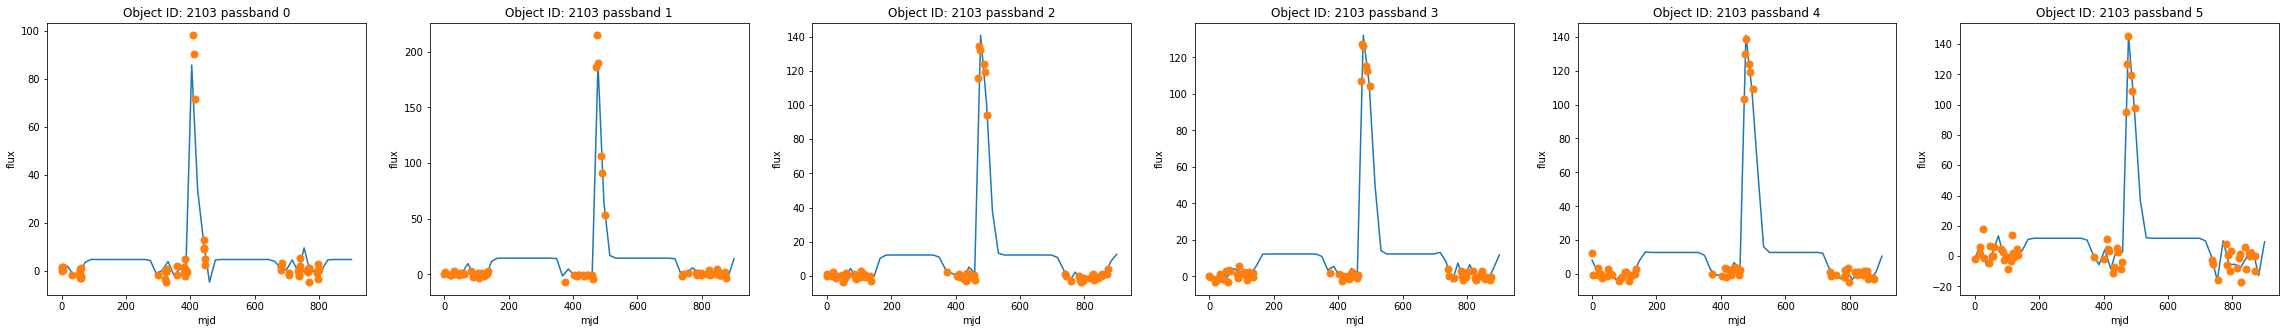

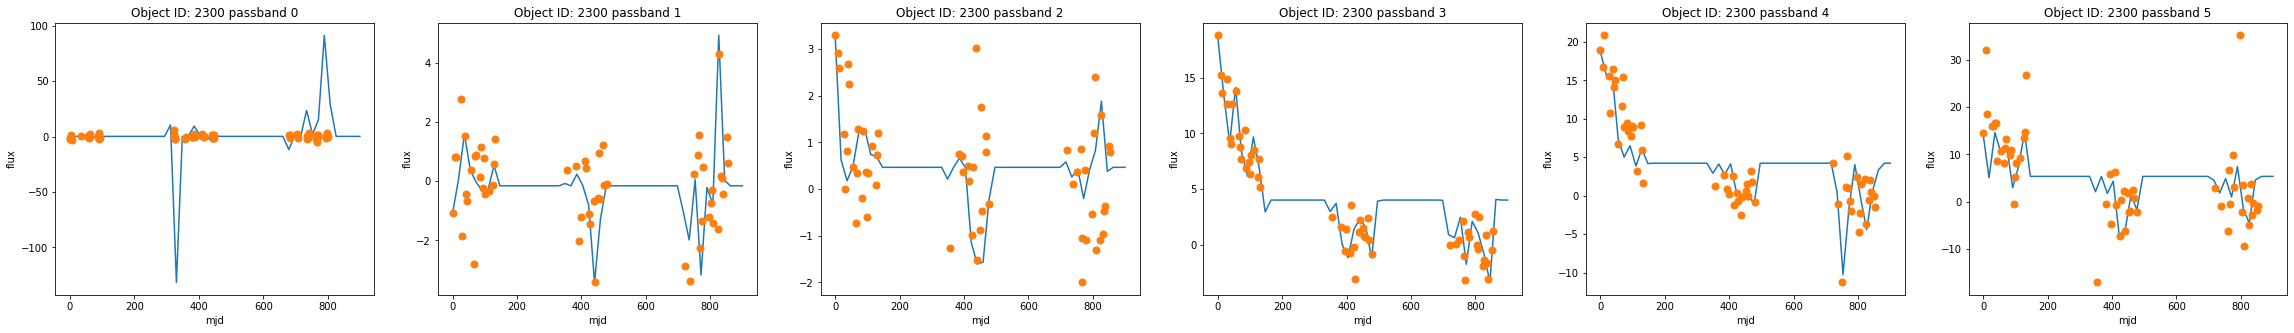

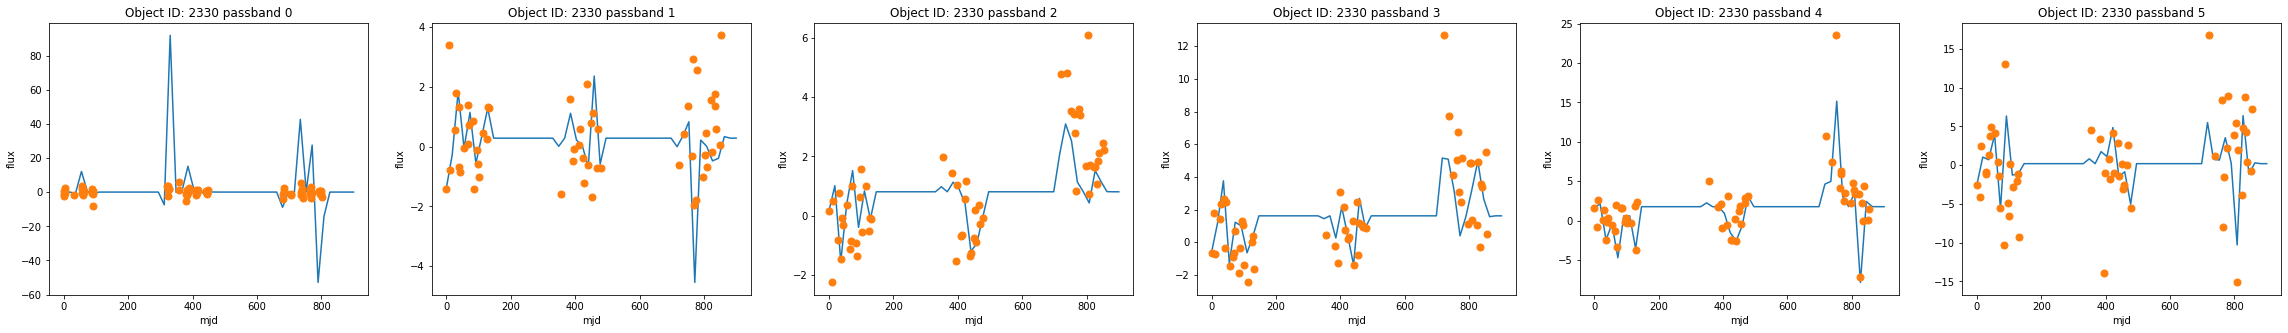

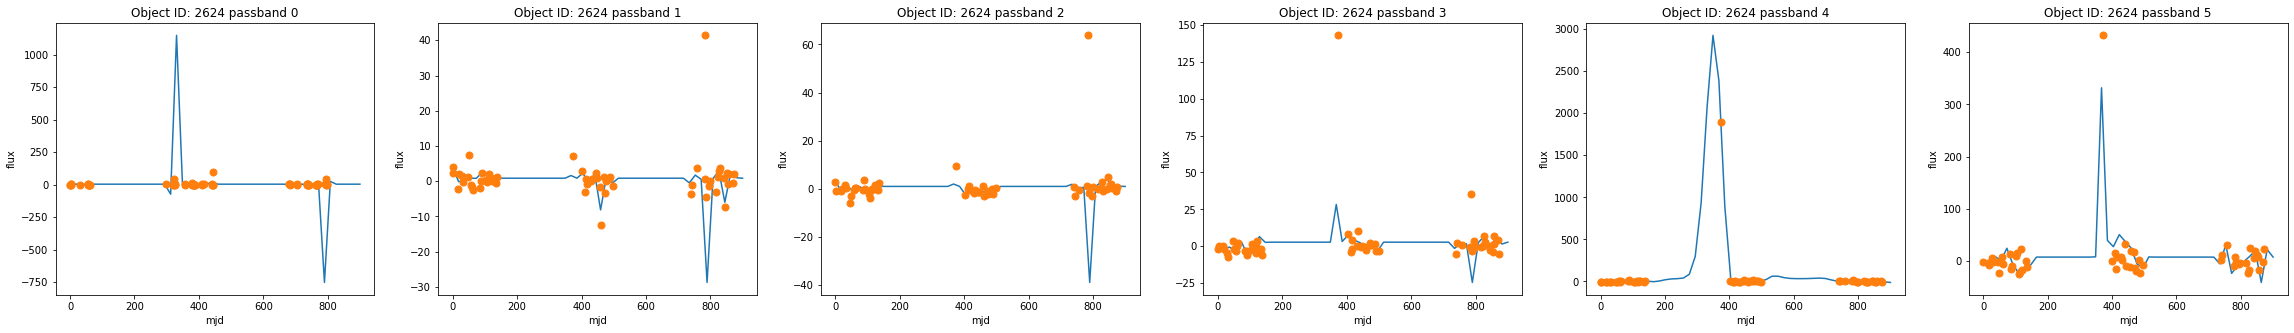

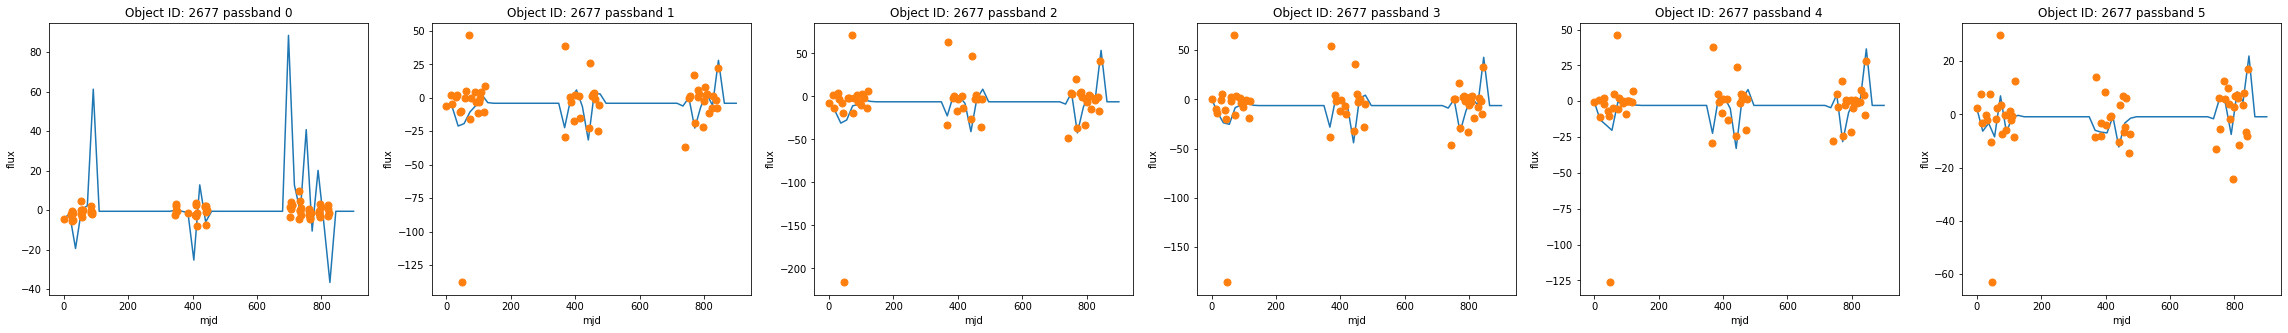

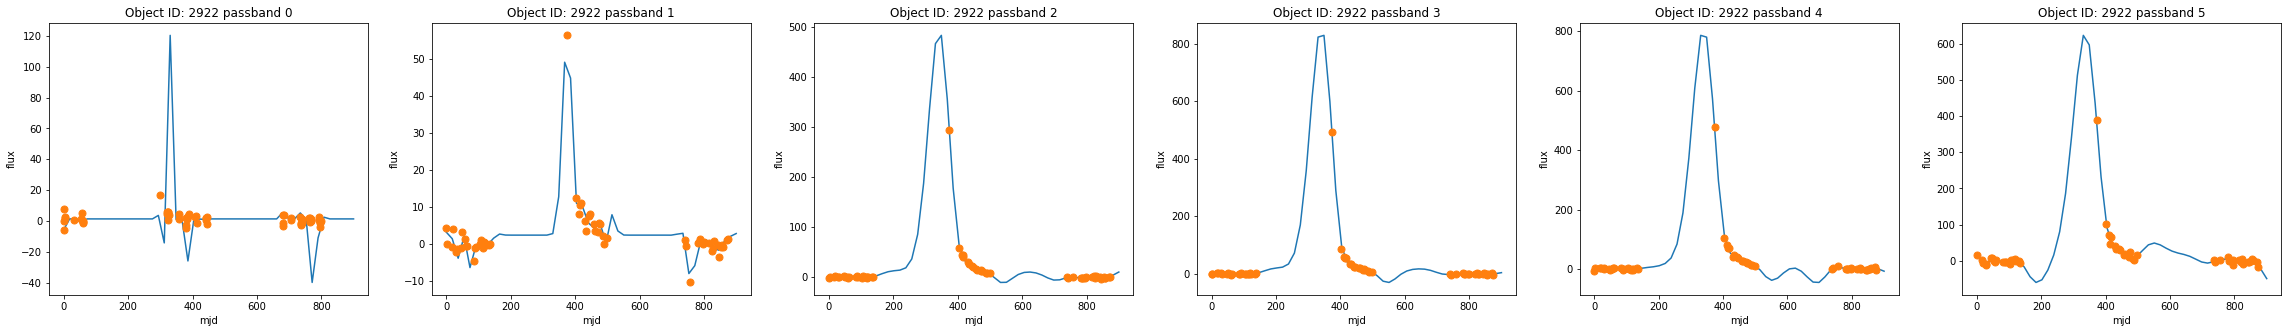

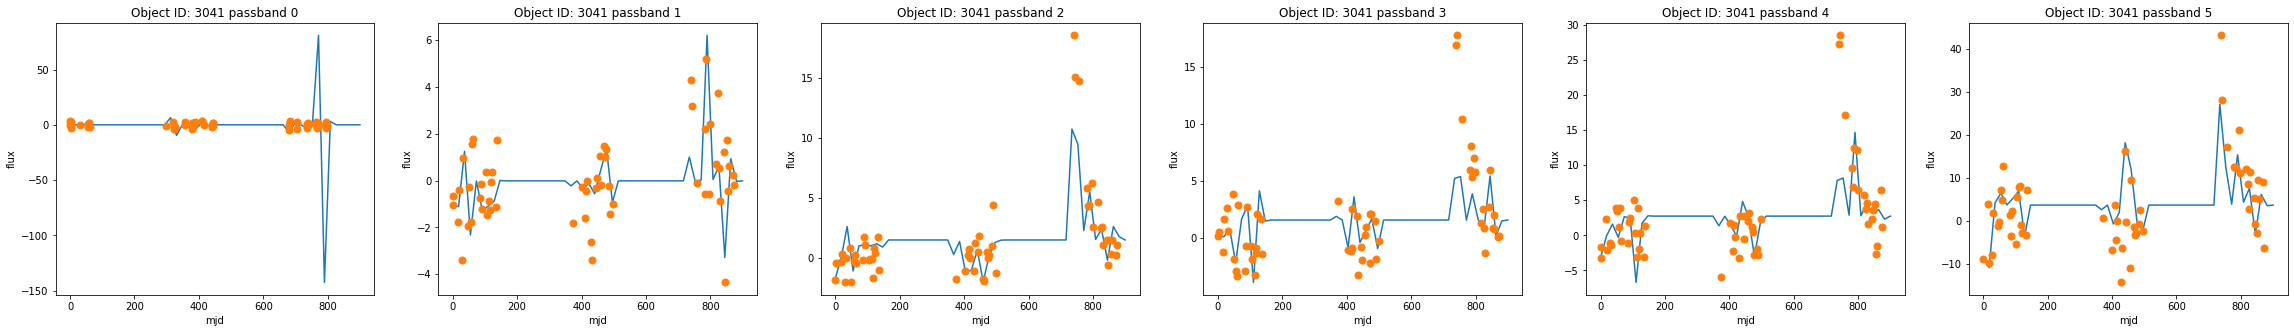

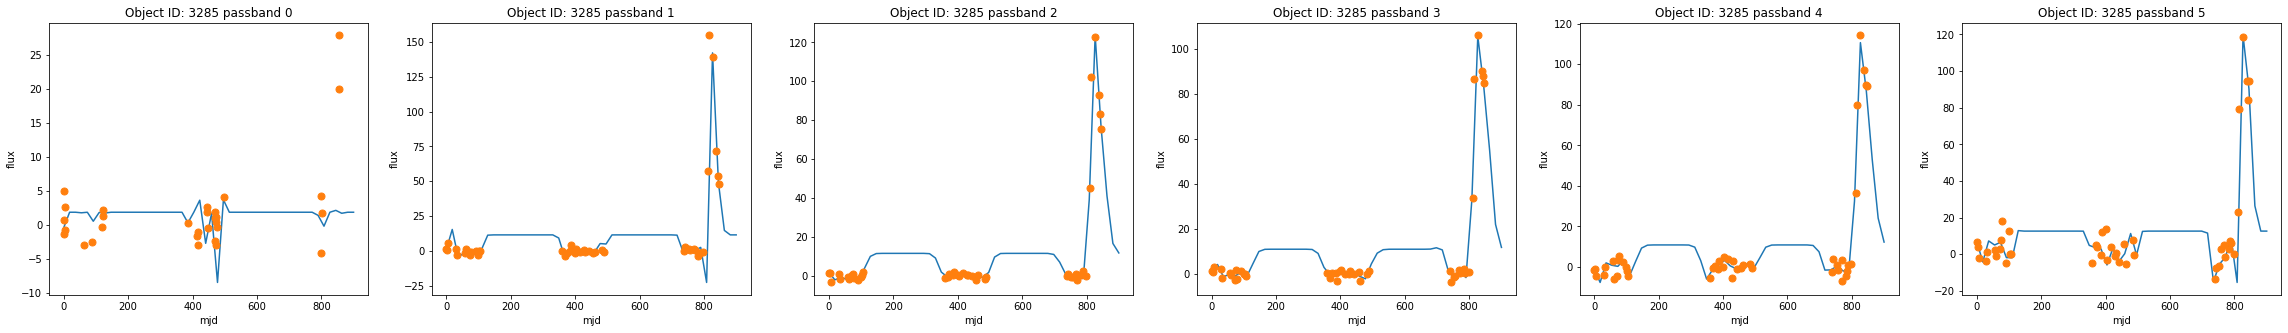

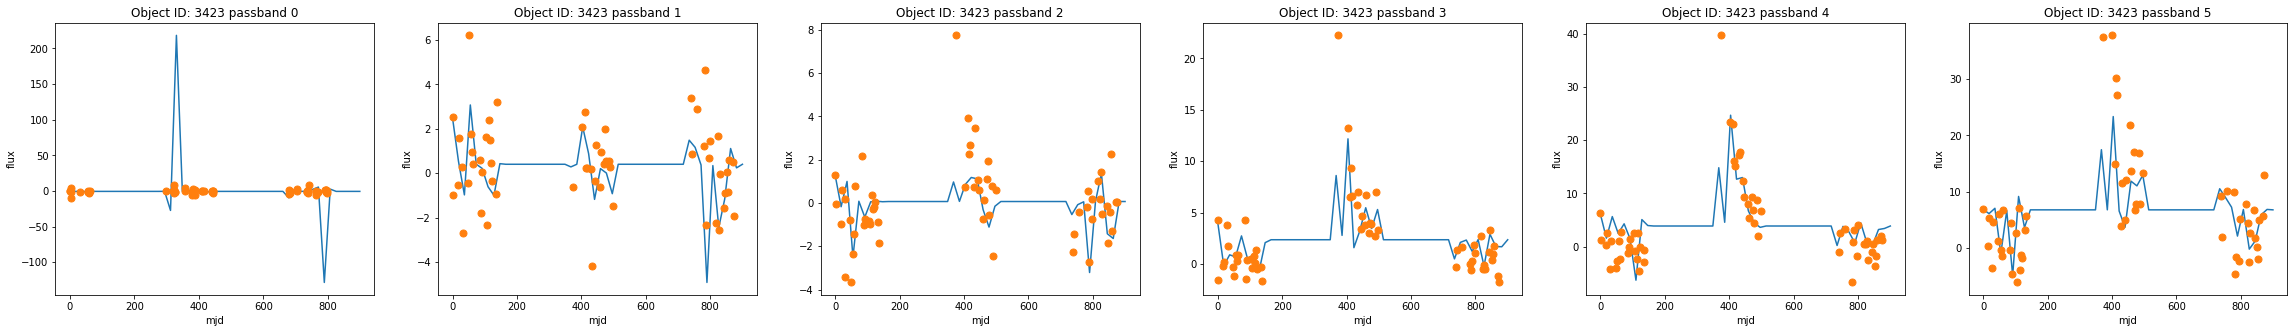

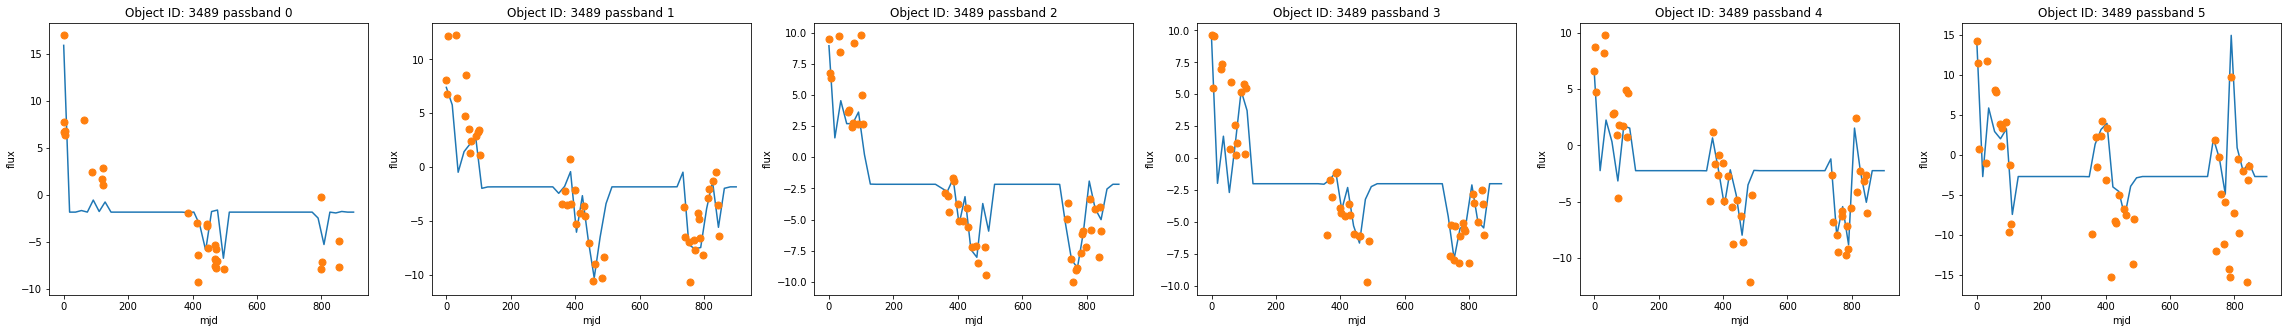

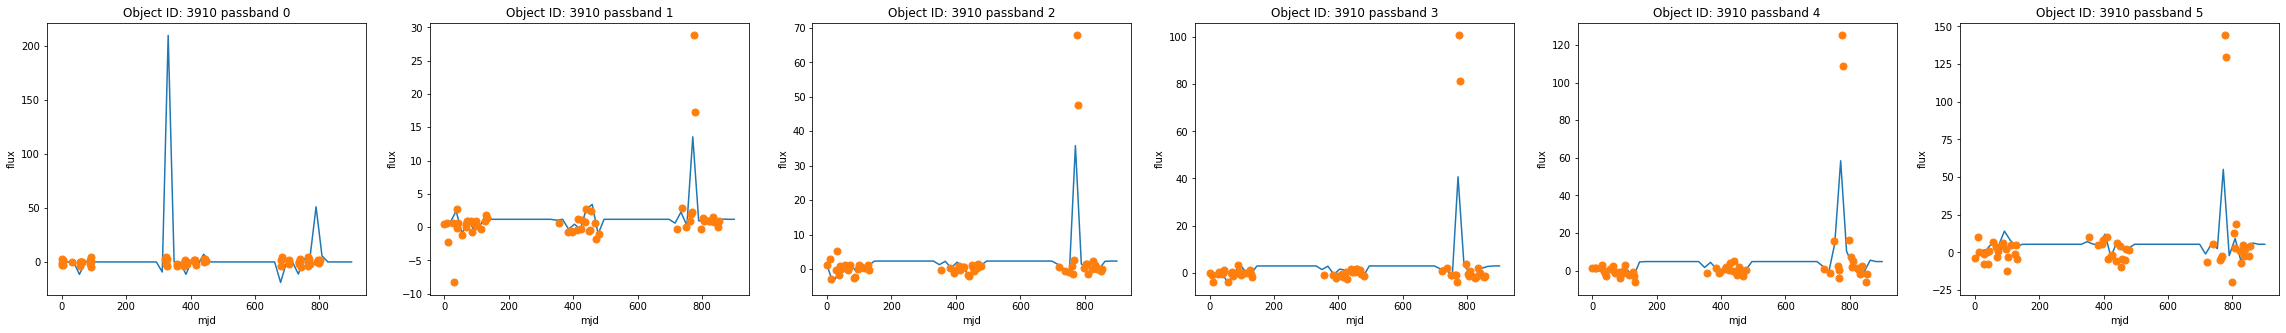

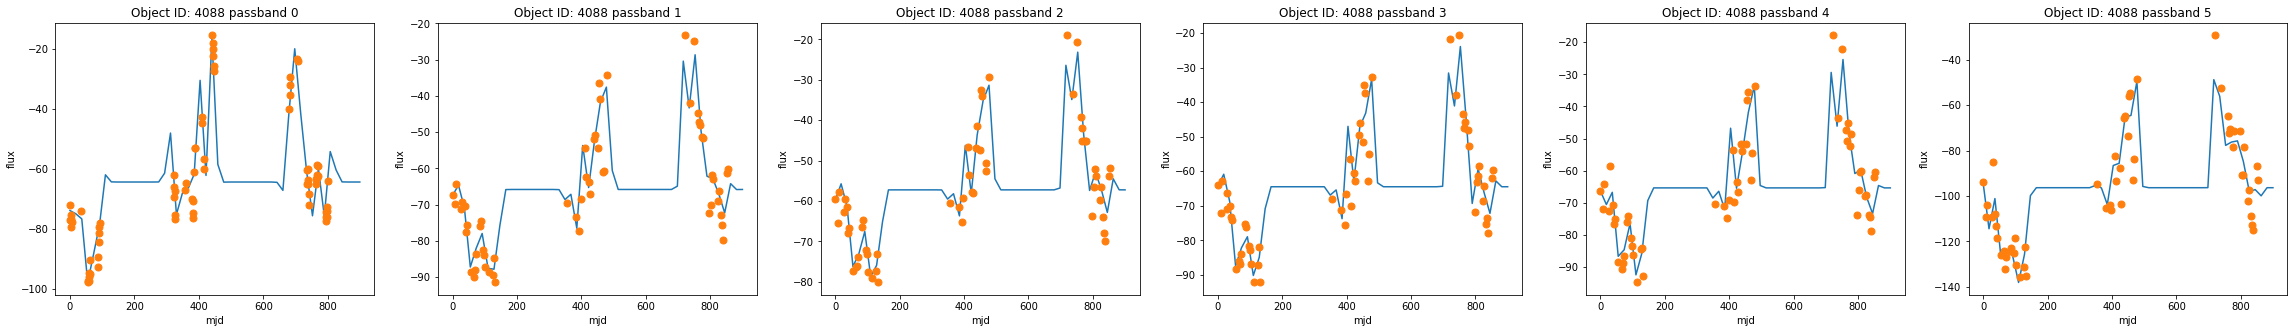

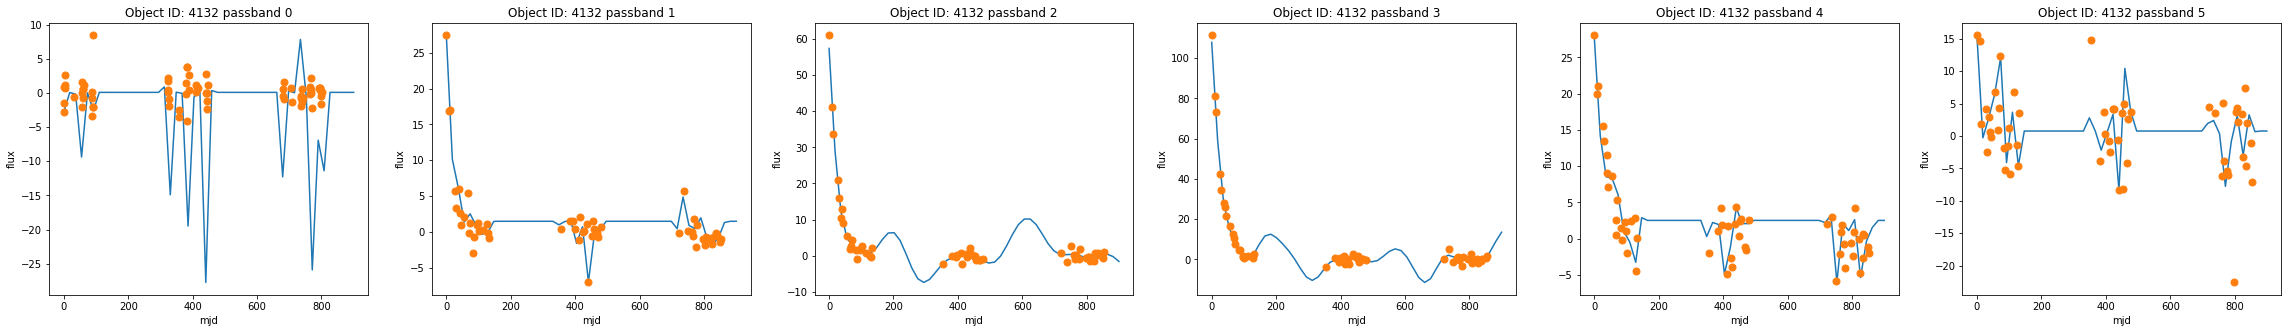

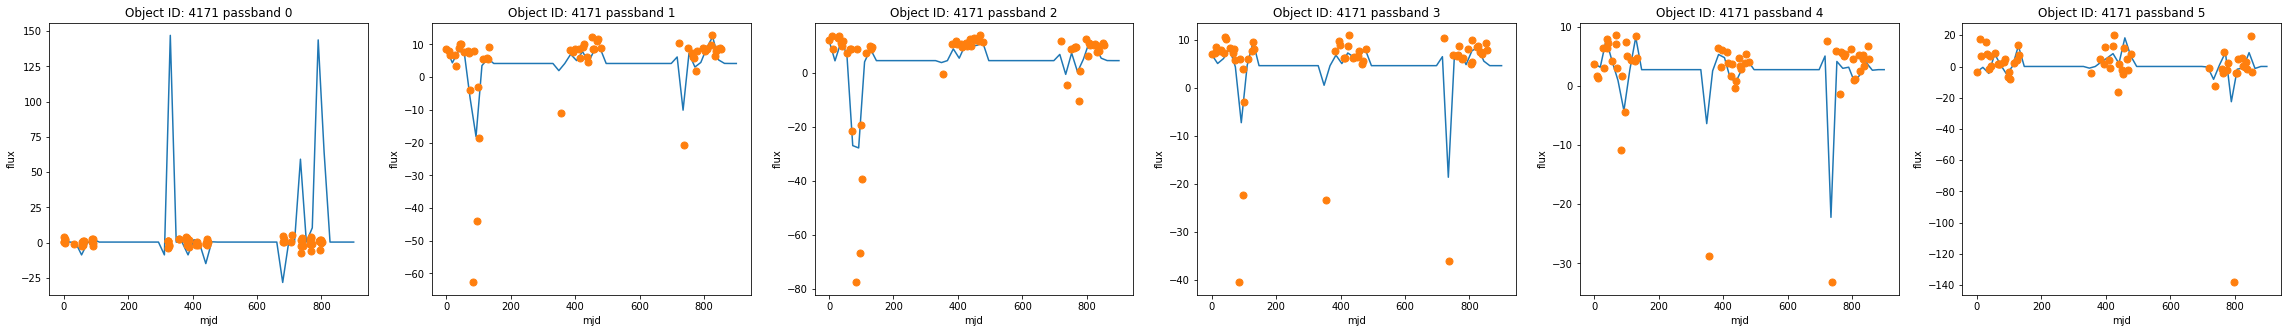

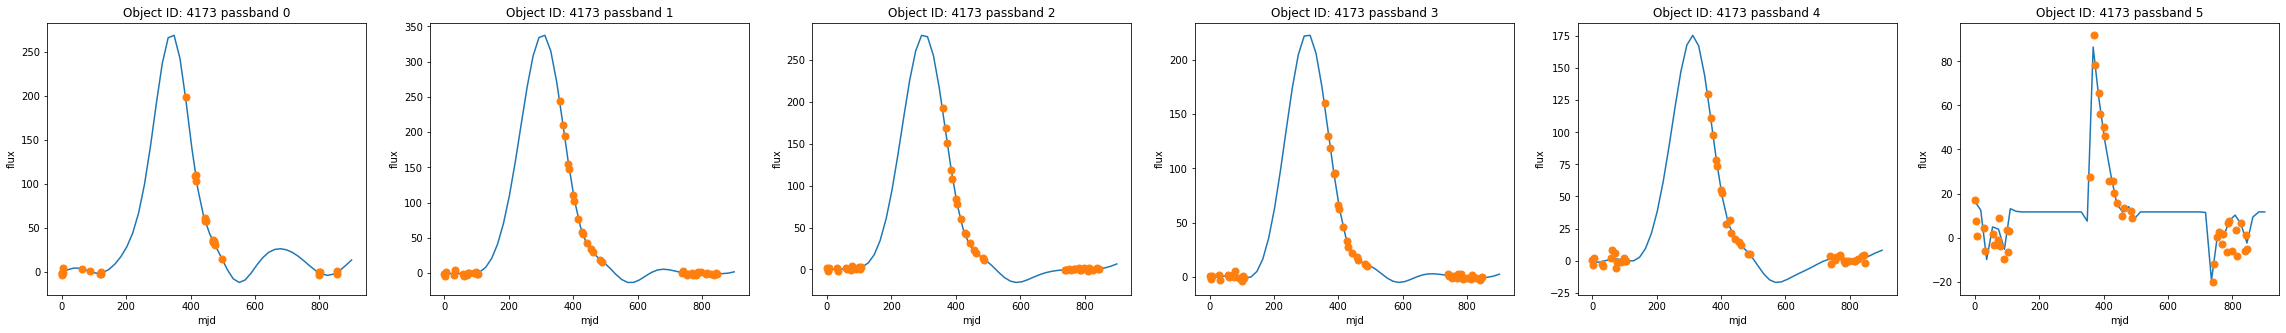

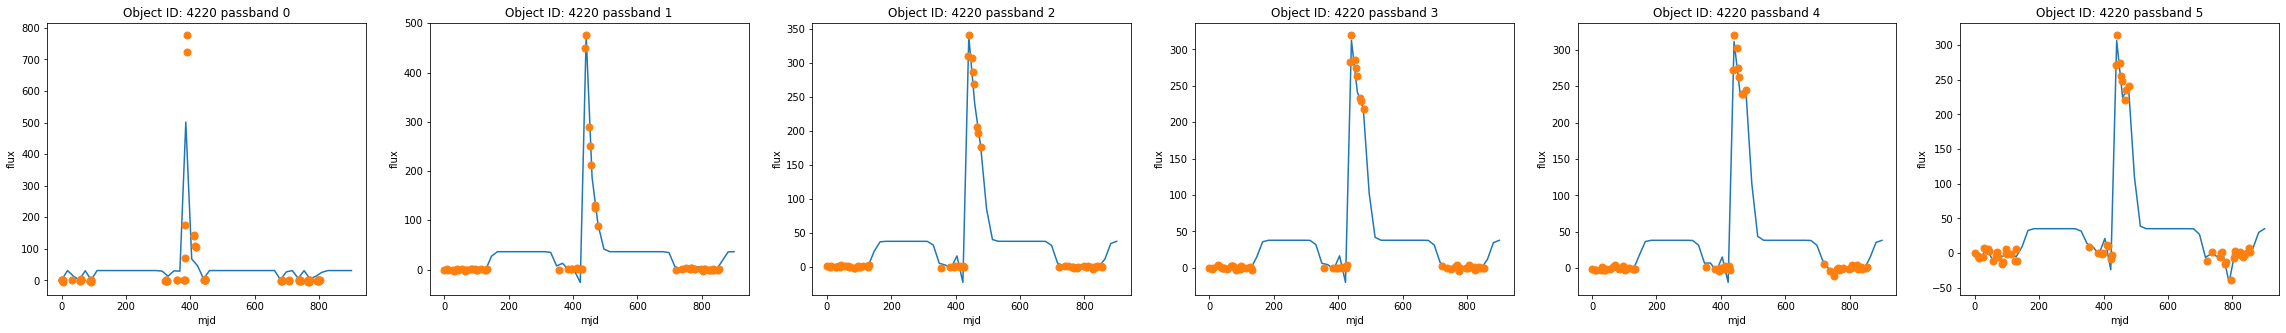

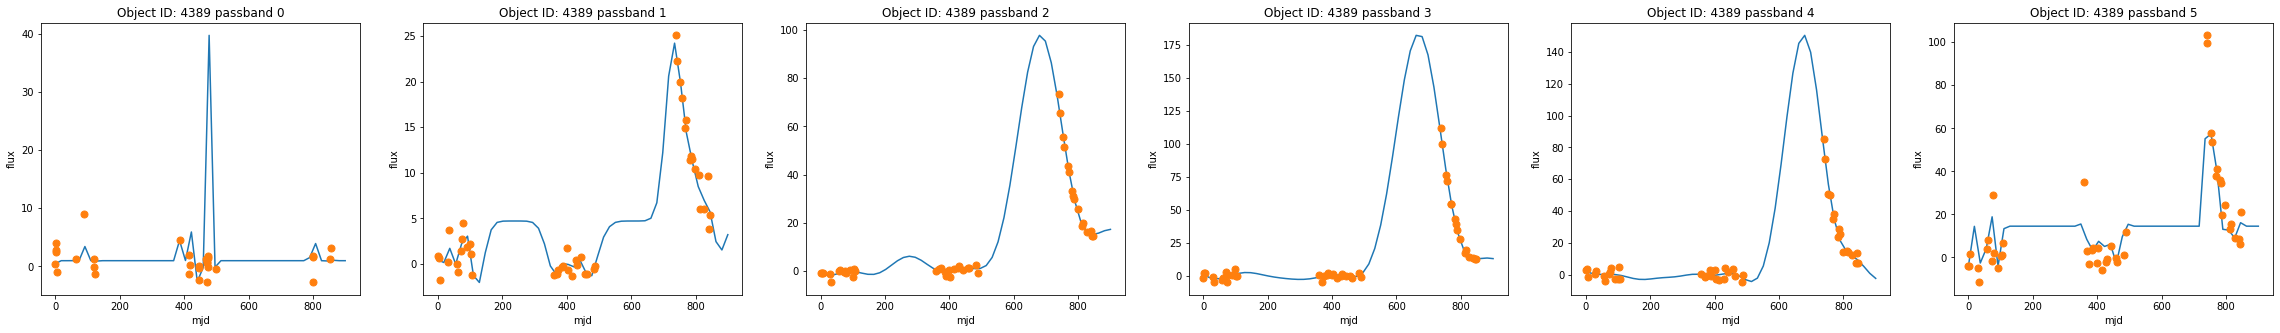

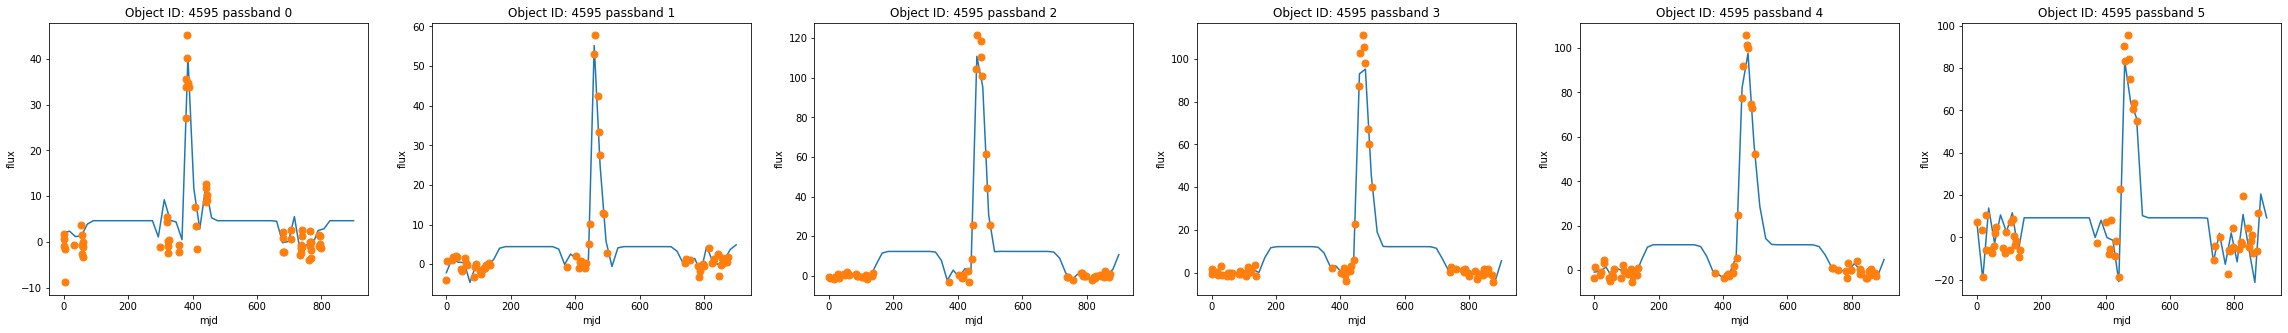

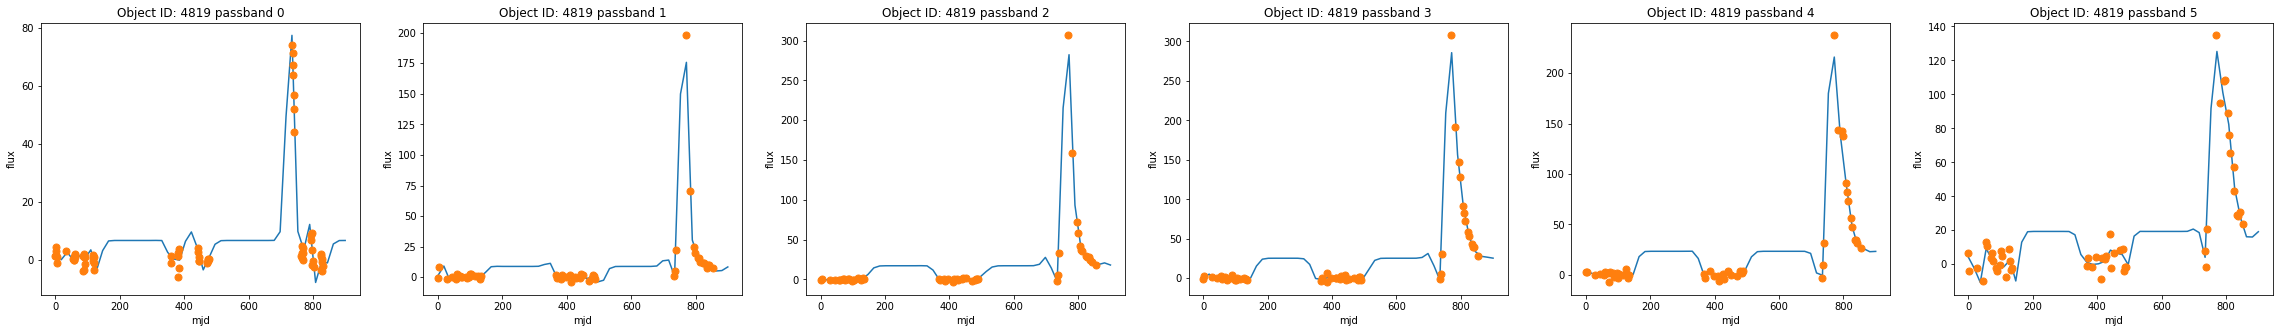

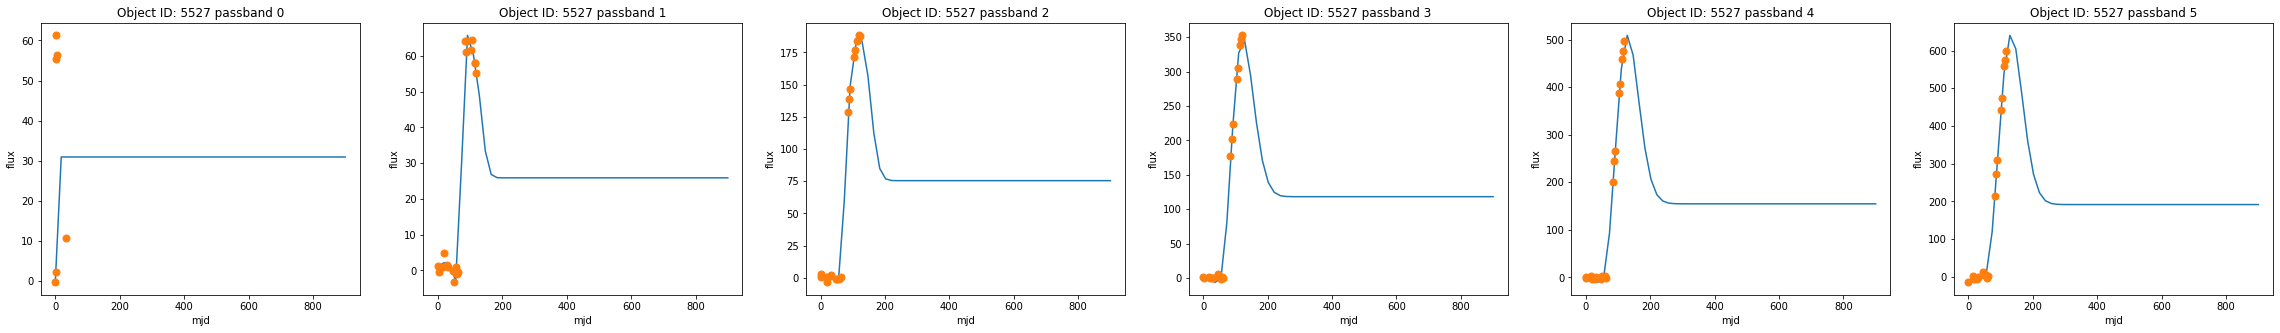

In [203]:
mjds = []
fluxs = []
object_ids = []
passbands = []

for i, obj in enumerate(list(lcvs.object_id.unique())):
    print('Fitting object {0}/{1}'.format(i+1, len(lcvs.object_id.unique())))
    fig, ax = plt.subplots(1, 6, figsize=(40, 5))
    for p in range(6):
        mjd = lcvs[lcvs.object_id == obj][lcvs.passband == p]['mjd'].to_numpy()
        mjd = mjd - mjd[0]  # Set initial time to '0'
        flux = lcvs[lcvs.object_id == obj][lcvs.passband == p]['flux'].to_numpy()
        detected = lcvs[lcvs.object_id == obj][lcvs.passband == p]['detected'].to_numpy()

        mjd_even, flux_even = make_gp(mjd, flux)
        
        mjds.append(mjd_even)
        fluxs.append(flux_even)
        object_ids.append(np.ones(len(mjd_even)) * obj)
        passbands.append(np.ones(len(mjd_even)) * p)

        ax[p].plot(mjd_even, flux_even, label='Gaussian process')
        ax[p].errorbar(mjd, flux, fmt='o', markersize=7, label='data')
        ax[p].set_title('Object ID: {0} passband {1}'.format(obj, p))
        ax[p].set_ylabel('flux')
        ax[p].set_xlabel('mjd')

    fig.show();

**Figure 1:** The above figures plot the flux of each passband of each object against time. The data points are the actual observations, while the smooth line is the Gaussian Process fit to the data points.

In [0]:
mjds = np.array(mjds)
fluxs = np.array(fluxs)
passbands = np.array(passbands)
object_ids = np.array(object_ids)

np.save('mjds.npy', mjds)
np.save('fluxs.npy', fluxs)
np.save('passbands.npy', passbands)
np.save('object_ids.npy', object_ids)

mjds = np.load('mjds.npy')
fluxs = np.load('fluxs.npy')
passbands = np.load('passbands.npy')
object_ids = np.load('object_ids.npy')

In [0]:
object_ids_adj = object_ids.reshape(object_ids.shape[0] // 6, object_ids.shape[1] * 6).astype(int)
mjds_adj = mjds.reshape(mjds.shape[0] // 6, mjds.shape[1] * 6)
fluxs_adj = fluxs.reshape(fluxs.shape[0] // 6, fluxs.shape[1] * 6)
passbands_adj = passbands.reshape(passbands.shape[0] // 6, passbands.shape[1] * 6)

In [0]:
gp_data = pd.DataFrame(fluxs_adj, index=object_ids_adj[:, 0])
gp_data.to_csv('gp_data.csv')

In [220]:
gp_data = pd.read_csv('gp_data.csv', index_col=0)
gp_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
615,14.205290,-3.254794,-17.594481,-95.853645,-3.22834,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-18.405307,-1.797768,6.926693,-1.294247,-3.943007,-171.094849,27.193005,-3.711958,106.478846,-3.255067,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,115.858911,-5.712001,-3.035003,...,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-174.999023,-47.465714,173.300637,-63.940832,334.708780,401.892939,-263.875601,267.907472,-47.449812,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-217.741797,228.402636,-39.547073,-143.581334,-24.031182,294.075903,-321.548401,-5.085846,-47.711789,-47.449847
713,7.229668,2.502558,-4.332575,7.858706,-2.78769,4.216353,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720473,5.955648,-2.720348,3.846664,-3.673723,-3.837843,-5.406312,-2.720726,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-8.503020,-3.778940,...,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794174,3.591356,1.624504,-2.921820,-2.434583,-11.367664,7.924978,10.227787,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-2.381300,-6.566577,-4.936324,-7.320891,-2.605248,-10.557038,-3.967171,-1.794175,-1.794175,-1.794175
730,-2.173553,-0.104508,-0.729180,5.373764,-2.38155,-0.130487,-16.987469,43.222868,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,0.273233,-1.084017,-33.302099,-0.048084,-0.048078,8.335436,1.014453,23.158839,-0.048078,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048075,...,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.538831,-8.559891,-8.309715,1.134207,14.973735,-16.362624,3.547762,9.282161,-0.757994,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.541632,47.572787,4.679201,27.295363,9.240930,2.738468,10.331151,-10.761004,4.197170,4.539396,4.539396
745,0.622941,1.790101,0.959057,-5.925442,1.74626,1.212538,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,5.781772,58.347495,1.635586,2.120086,-11.233893,-3.870690,3.479920,5.364236,1.799429,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,-5.325032,2.143570,1.697885,...,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746156,11.504382,104.908780,55.015473,74.285960,57.020417,40.430753,23.875817,16.947488,13.349889,10.302851,10.746010,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746132,10.582427,-2.448286,-1.461519,1.226901,3.504546,20.552746,-3.130115,-6.420048,-22.869636,12.926757,10.749742,10.746138
1124,-0.242689,0.656053,0.354396,1.387742,0.56526,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.791380,4.925386,-67.828332,0.646001,0.543900,-12.124328,-4.323038,0.496293,5.359531,0.660843,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,8.772855,0.084856,0.681845,...,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896741,4.748905,6.885143,0.291131,0.882499,7.931248,12.368219,

# Create and Train the Autencoder

In [0]:
X_train, X_test, y_train, y_test = train_test_split(gp_data, gp_data, test_size=0.25, random_state=667)

In [294]:
X_train.shape

(23, 300)

In [326]:
model = Sequential()
model.add(Dense(300, activation='relu', kernel_initializer='he_uniform', input_dim=300))
model.add(Dense(100, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(300, activation='relu'))

model.compile(optimizer='adamax', loss='mse', metrics=['mae'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_82 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_83 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_84 (Dense)             (None, 100)               2600      
_________________________________________________________________
dense_85 (Dense)             (None, 300)               30300     
Total params: 155,825
Trainable params: 155,825
Non-trainable params: 0
_________________________________________________________________
None


In [327]:
history = model.fit(X_train.values, y_train.values, epochs=1000, batch_size=5, verbose=1)
model.save("model.h5")

Epoch 1/1000
23/23 [==============================] - 0s 6ms/step - loss: 8970.7718 - mae: 26.6216
Epoch 2/1000
23/23 [==============================] - 0s 885us/step - loss: 8447.7124 - mae: 25.3299
Epoch 3/1000
23/23 [==============================] - 0s 705us/step - loss: 8209.3682 - mae: 25.1795
Epoch 4/1000
23/23 [==============================] - 0s 708us/step - loss: 8056.8955 - mae: 25.3339
Epoch 5/1000
23/23 [==============================] - 0s 693us/step - loss: 7877.9239 - mae: 25.1873
Epoch 6/1000
23/23 [==============================] - 0s 714us/step - loss: 7564.3580 - mae: 25.0629
Epoch 7/1000
23/23 [==============================] - 0s 728us/step - loss: 7388.5070 - mae: 24.7900
Epoch 8/1000
23/23 [==============================] - 0s 666us/step - loss: 7107.9822 - mae: 24.4205
Epoch 9/1000
23/23 [==============================] - 0s 725us/step - loss: 6780.5801 - mae: 23.9731
Epoch 10/1000
23/23 [==============================] - 0s 705us/step - loss: 6415.5921 - mae:

# Model Validation

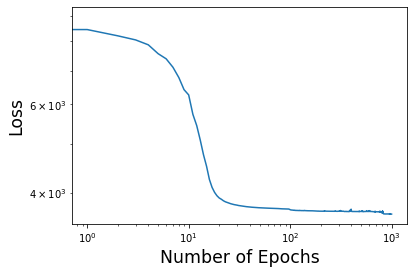

In [328]:
plt.plot(np.array(history.history['loss']))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Epochs', fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large');

In [0]:
y_pred = model.predict(X_test)

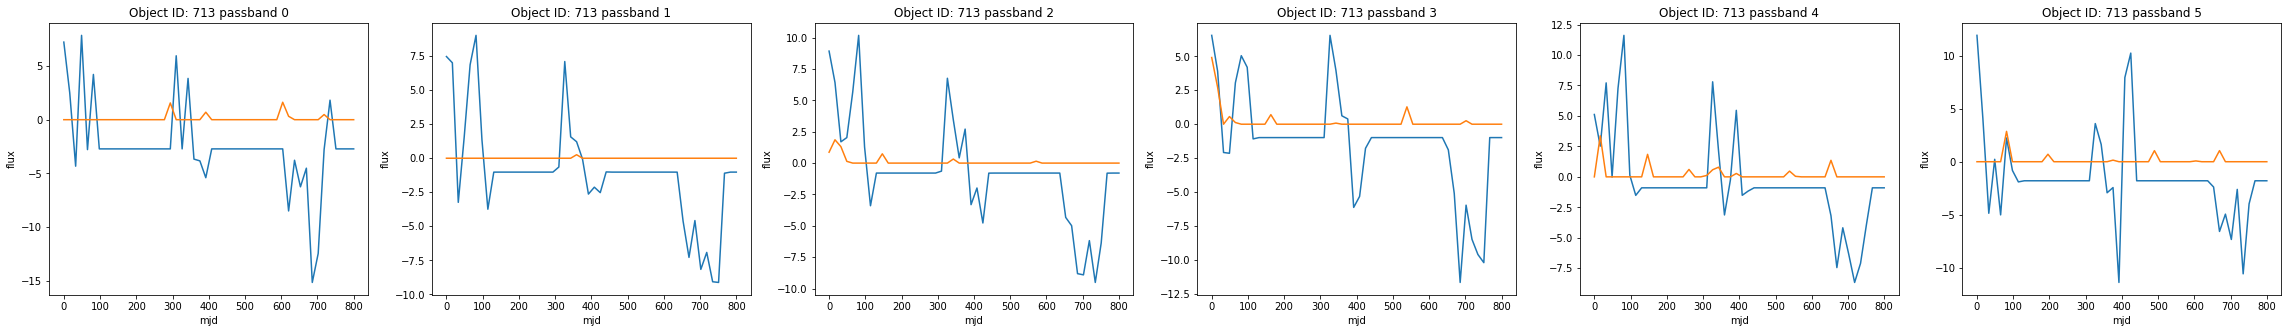

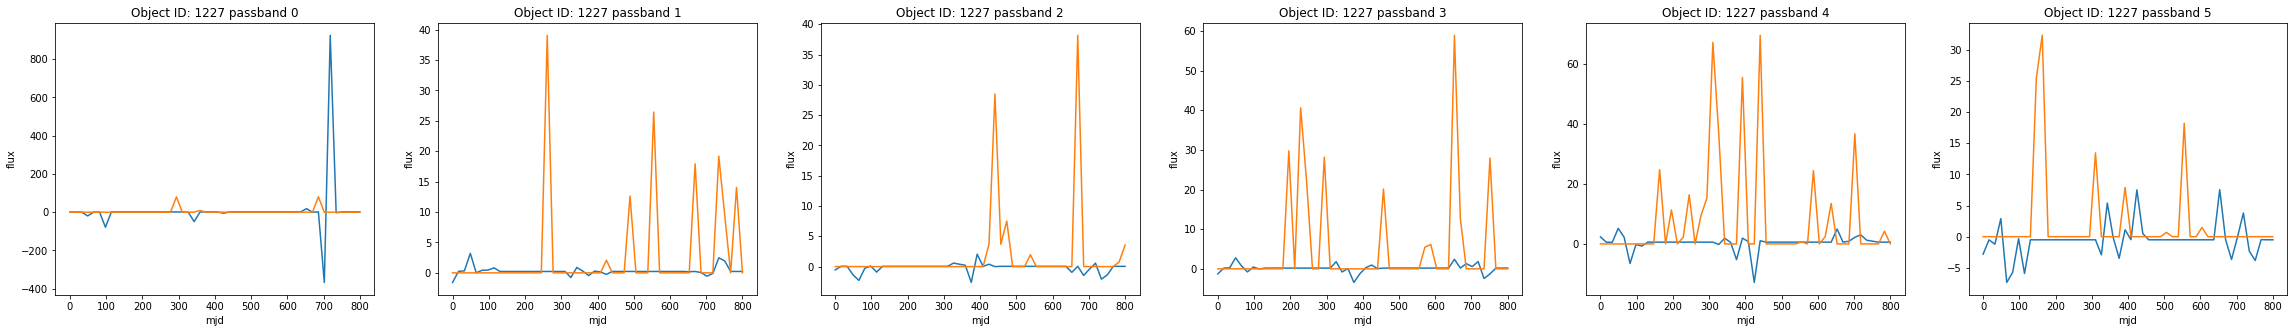

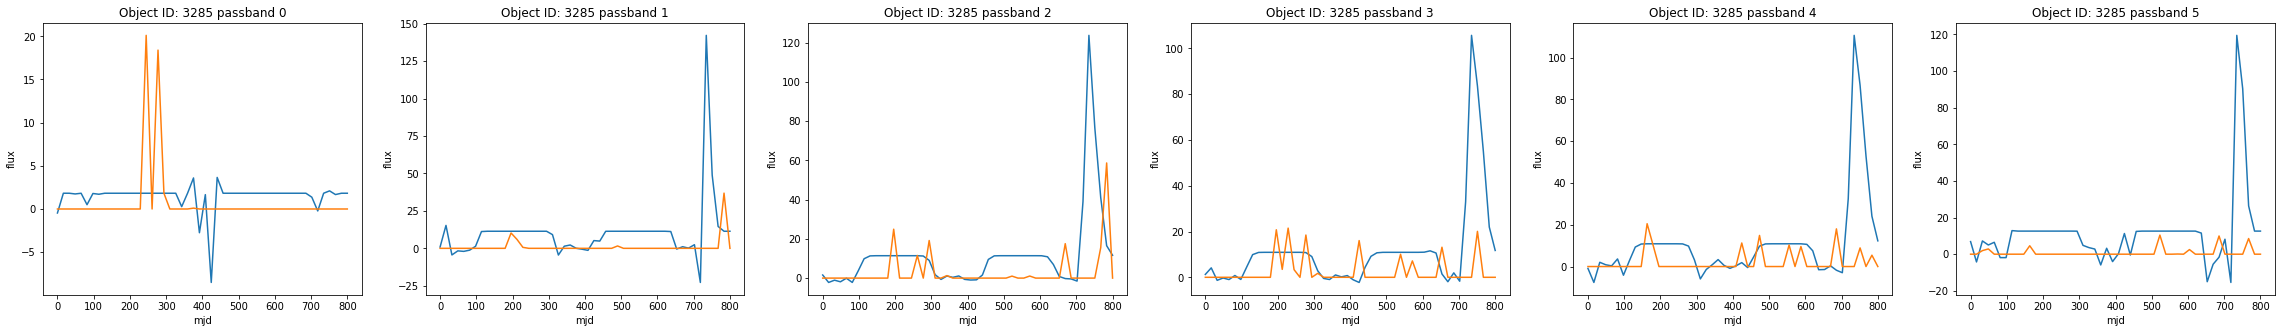

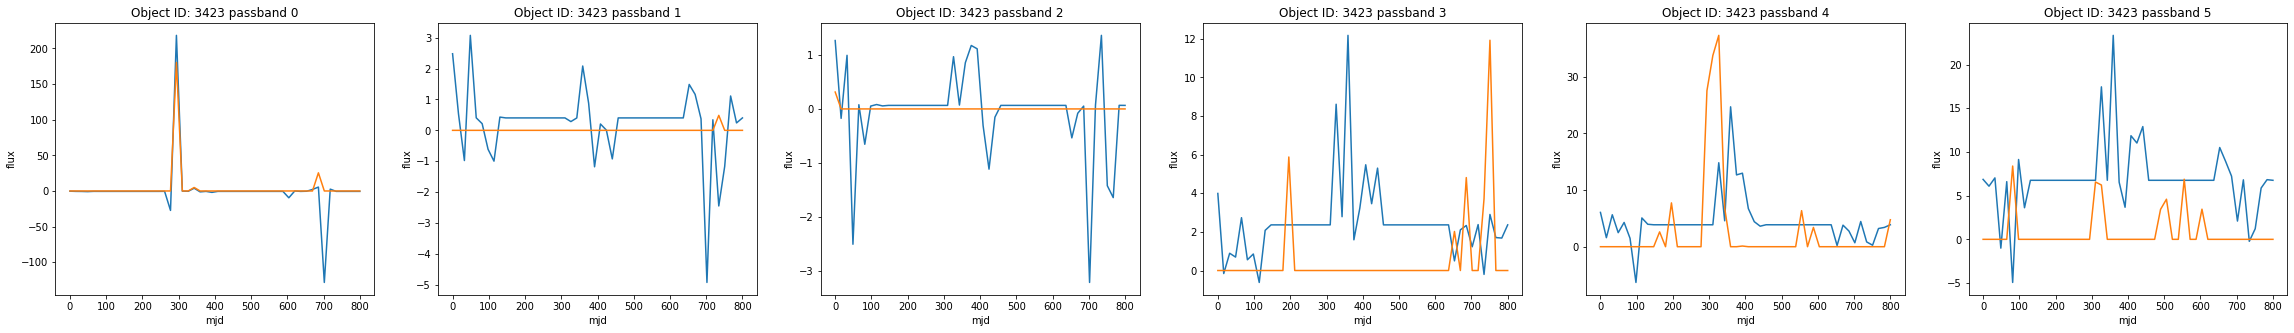

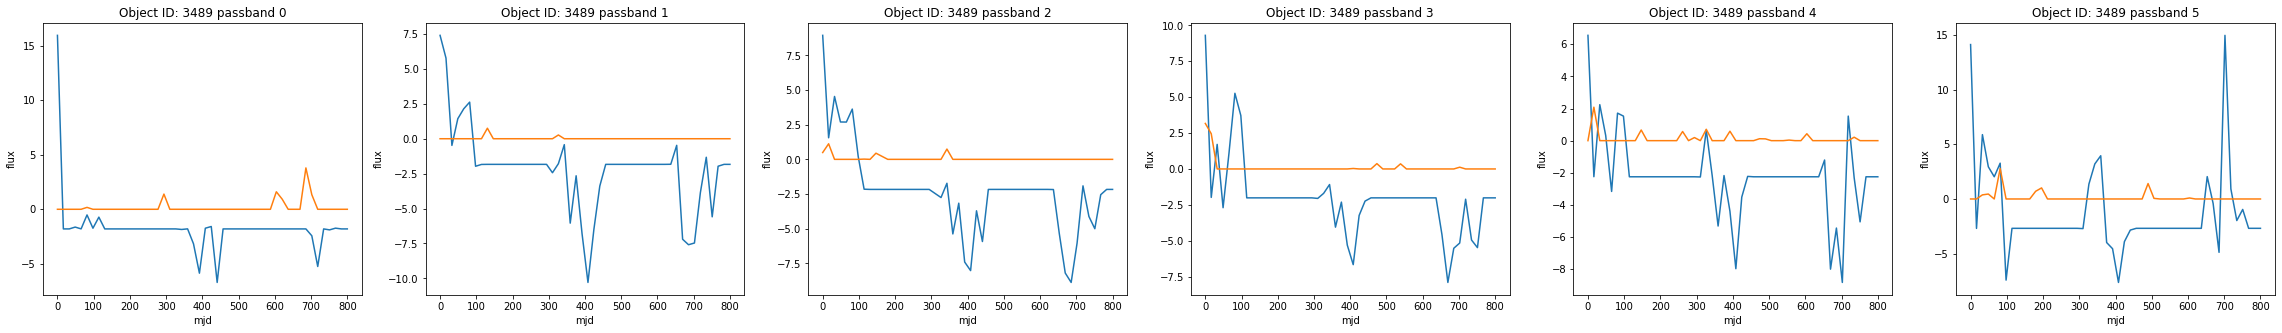

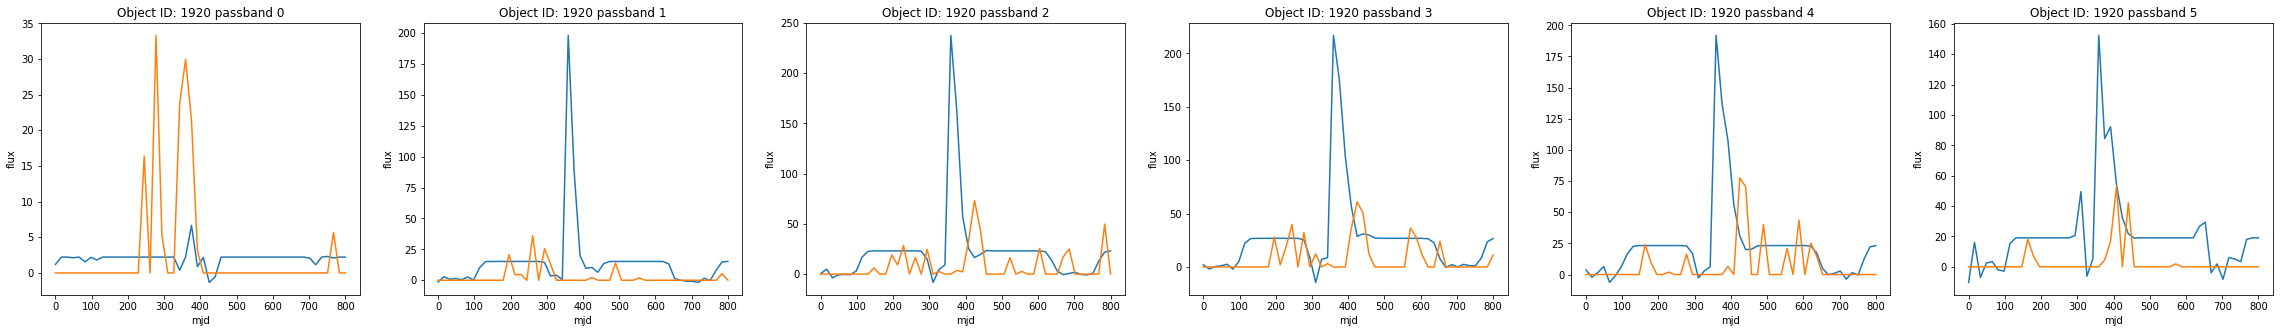

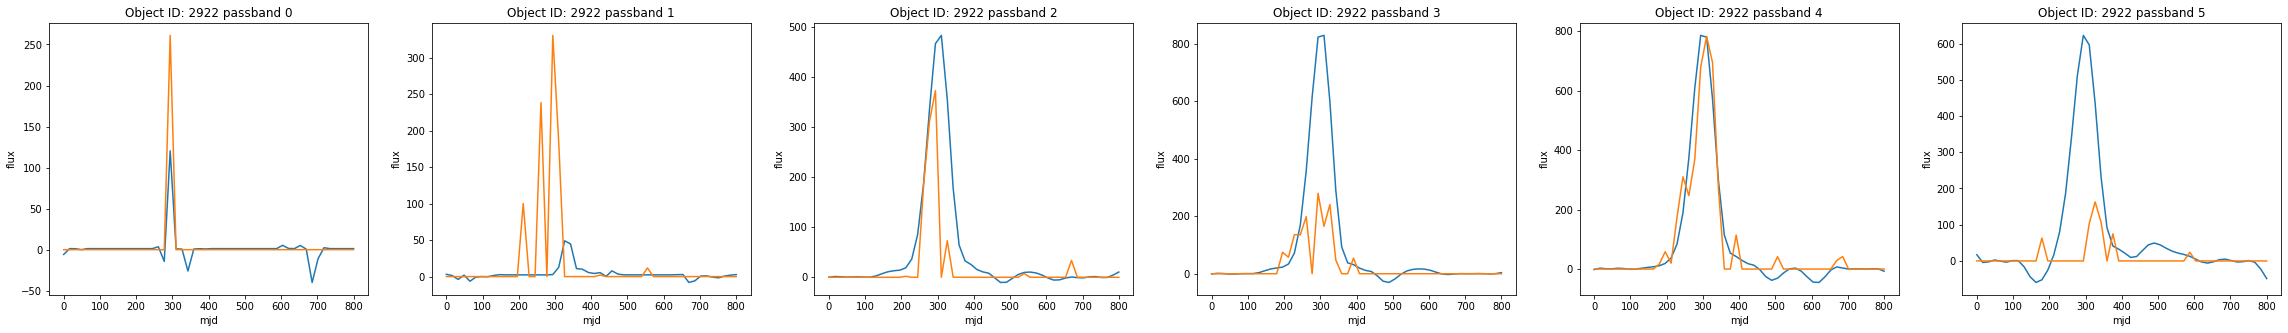

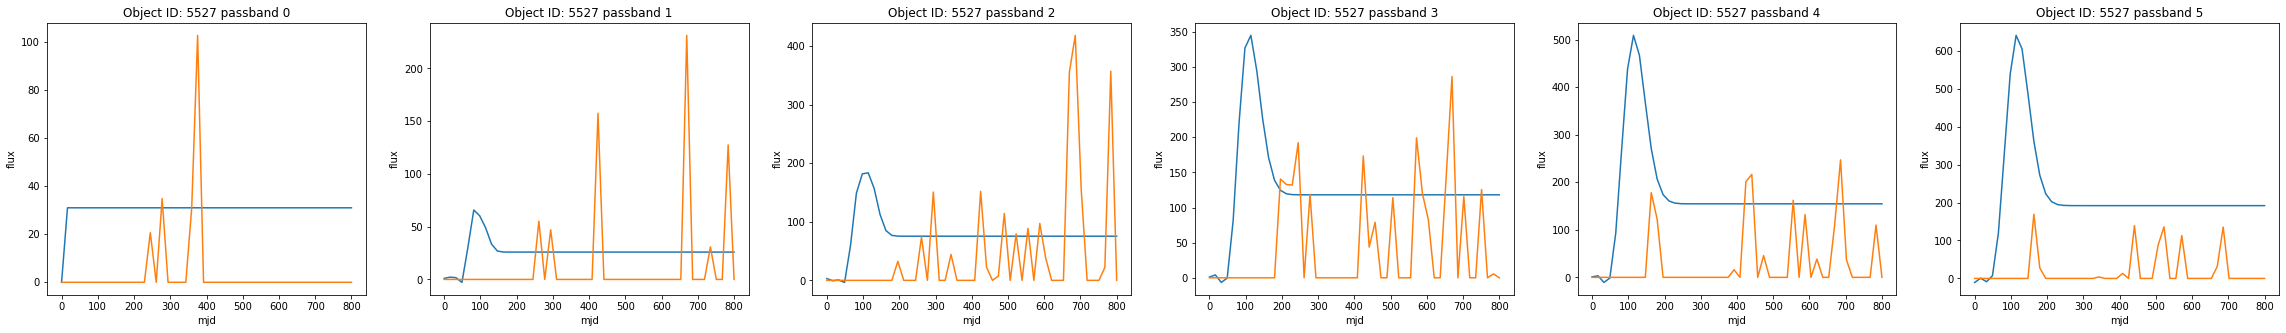

In [330]:
for i in range(len(X_test)):
    fig, ax = plt.subplots(1, 6, figsize=(40, 5))
    for p in range(6):
        test_mjds = np.linspace(0, 800)
        orig = X_test.values[i].reshape(6, 50)
        pred = y_pred[i].reshape(6, 50)

        ax[p].plot(test_mjds, orig[p], label='original series')
        ax[p].plot(test_mjds, pred[p], label='re-created series')

        ax[p].set_title('Object ID: {0} passband {1}'.format(X_test.index[i], p))
        ax[p].set_ylabel('flux')
        ax[p].set_xlabel('mjd')
    fig.show();

# Classifiy the Light Curves

Using the bottlenecked values generated by the autoencoder, as well as the object features used in the PLAsTiCC challenge assignment, I will classify the light curves

In [278]:
allfeatures = pd.read_csv('allfeatures.csv', index_col=0)
allfeatures.head()

,"(0, 'stds')","(0, 'kurt')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll2')","(1, 'stds')","(1, 'kurt')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll2')","(2, 'stds')","(2, 'kurt')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll2')","(3, 'stds')","(3, 'kurt')","(3, 'median')","(3, 'slopes')","(3, 'intercepts')","(3, 'll2')","(4, 'stds')","(4, 'kurt')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll2')","(5, 'stds')","(5, 'kurt')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll2')",decl,ddf,target
0,83.944735,7.433032e+07,-0.080537,0.005676,-0.175947,-84.013092,601.787302,2.215166e+11,-0.170090,0.014032,-0.399902,-80.867915,455.121346,6.659406e+10,-0.289021,0.017676,-0.503760,-80.092803,335.425053,1.919999e+10,-0.122434,0.020475,-0.583524,-79.226482,291.803449,1.036570e+10,-0.163078,0.022343,-0.636786,-78.160027,294.779522,1.049535e+10,-0.129163,0.021319,-0.596932,-76.917754,-61.943836,1,92
1,7.113509,4.907398e+03,-0.052914,-0.041433,1.429423,-45.801483,5.712334,1.944373e+03,0.080189,-0.051648,1.420320,-36.052358,5.770738,1.935955e+03,0.117188,-0.053887,1.481892,-34.410798,6.450413,3.091660e+03,0.141552,-0.050983,1.402038,-38.701863,6.406989,2.938985e+03,0.016870,-0.050464,1.387765,-44.424807,7.094073,5.294322e+03,-0.094281,-0.037903,1.042343,-65.167686,-27.784405,1,88
2,1.828872,3.655013e+01,0.039463,-0.001798,0.063840,-101.249926,1.807229,3.870188e+01,0.016754,0.003167,-0.080770,-72.910038,5.559483,6.926529e+03,-0.343392,0.026905,-0.686084,-63.777334,8.191987,4.048490e+04,-0.314425,0.024491,-0.624531,-66.369632,10.710344,1.060595e+05,-0.308522,0.022552,-0.563811,-65.239486,13.332758,1.860606e+05,-0.149763,0.019612,-0.490299,-66.518080,-6.579593,1,42
3,4.374445,2.575248e+03,-0.169349,-0.013089,0.464675,-88.423048,25.964659,2.162844e+07,-0.185994,-0.003826,0.105205,-76.313623,31.957997,3.606109e+07,-0.290606,-0.003878,0.106641,-72.846380,34.967698,2.575691e+07,-0.373246,-0.003931,0.108112,-67.105516,33.069053,1.781661e+07,-0.358773,-0.004774,0.131296,-67.067827,26.060130,6.203072e+06,-0.306851,-0.002816,0.076043,-64.783463,-45.586655,1,90
4,2.360084,1.101222e+02,-0.033864,0.017117,-0.530614,-84.959510,8.107525,3.545471e+04,-0.429236,0.028666,-0.816982,-67.527468,21.319854,2.468546e+06,-0.438785,0.025384,-0.723449,-71.247906,26.270649,7.271993e+06,-0.383411,0.021342,-0.608237,-74.498916,26.865913,9.005039e+06,-0.303771,0.019736,-0.562470,-75.898716,21.434627,3.279413e+06,-0.229697,0.015555,-0.435534,-76.526495,-63.823658,1,90


In [0]:
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).iloc[:, 1:]
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

In [0]:
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations:\n ", 
      X_scaled.mean(axis=0), '\n', X_scaled.std(axis=0))

In [0]:
Xddf = X[metadata.ddf == 1]
Xnormal = X[metadata.ddf == 0]
yddf =  y[metadata.ddf == 1]
ynormal =  y[metadata.ddf == 0]

In [0]:
X_trainddf, X_testddf, y_trainddf, y_testddf = train_test_split(Xddf, yddf, random_stat=667)
X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = train_test_split(Xnormal, ynormal, random_state=667)